# Data wrangling - reviews

**Filename of dataset**
- selected_reviews.json - only products used in the other dataset
- full_reviews.json - all reviews of products scraped

________________________________________________________________________

# 1.0 Loading the files

### 1.1 Installations

In [2]:
#Import necessary libraries
import json 
import re
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from collections import Counter

In [3]:
#Libraries for text
import nltk
import spacy
import re
import contractions
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /Users/nikamurao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nikamurao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nikamurao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nikamurao/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### 1.2 Load the file 

In [12]:
with open('../data/raw_data/selected_reviews.json', 'r') as file:
    raw_data= json.load(file)
reviews=pd.DataFrame.from_dict(raw_data)

In [13]:
reviews

,reviewer,r_productid,r_star,r_eyecolor,r_haircolor,r_skintone,r_skintype,r_skinconcerns,r_review
0,kelsb5,P409800,5,blue,blonde,light,combination,acne,Love this mini compact wipes bag! I bought the...
1,fairytatiana,P409800,4,blue,brunette,light,combination,acne,"very good, it can take most of your makeup wit..."
2,baimhas,P409800,5,blue,blonde,porcelain,dry,calluses,Love the watermelon ones! Don’t have to rub ha...
3,haleymcm,P409800,2,None,None,None,None,None,I bought the green tea version of these wipes ...
4,mariahswannie,P409800,4,blue,brunette,porcelain,dry,darkCircles,"Nice and cleansing, only 10 wipes though"
...,...,...,...,...,...,...,...,...,...
35159,shhh72,P418301,5,blue,blonde,light,normal,aging,I put this on every morning after washing my f...
35160,eaazye,P418301,5,gray,brunette,light,combination,acne,"so this was a random purchase, i literally jus..."
35161,Mariemill,P418301,5,blue,blonde,fair,combination,aging,Was skeptical but took the plunge based solely...
35162,JaeW,P418301,3,None,None,None,None,None,I've been using pretty religiously for over 10...


# 2.0 Data wrangling

### 2.1 Data wrangling

In [14]:
reviews.describe()

,r_star
count,35164.000000
mean,4.238483
std,1.221904
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [15]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35164 entries, 0 to 35163
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewer        34924 non-null  object
 1   r_productid     35164 non-null  object
 2   r_star          35164 non-null  int64 
 3   r_eyecolor      27097 non-null  object
 4   r_haircolor     27159 non-null  object
 5   r_skintone      28850 non-null  object
 6   r_skintype      31127 non-null  object
 7   r_skinconcerns  25067 non-null  object
 8   r_review        35116 non-null  object
dtypes: int64(1), object(8)
memory usage: 2.4+ MB


**Check for duplicated entries**

In [16]:
#indicative of duplicated entries, expecting only a 100 reviews per product
reviews.r_productid.value_counts()[:125]

P412117    424
P445464    373
P414293    361
P460758    328
P452701    312
          ... 
P442752    128
P455636    128
P411869    128
P247716    126
P399751    125
Name: r_productid, Length: 125, dtype: int64

In [17]:
reviews.shape

(35164, 9)

In [18]:
#Drop duplicated entries
reviews.drop(reviews[reviews.duplicated(keep='first')].index, inplace=True)

In [19]:
reviews.shape

(18849, 9)

**Check missing data**

In [20]:
#Check for missing values
reviews.isnull().sum()

reviewer           137
r_productid          0
r_star               0
r_eyecolor        4587
r_haircolor       4604
r_skintone        3608
r_skintype        2391
r_skinconcerns    5598
r_review            19
dtype: int64

In [21]:
print(f'{round(reviews.isnull().any(axis=1).sum()/reviews.shape[0]*100,2)} % of the entries have a missing value')

31.95 % of the entries have a missing value


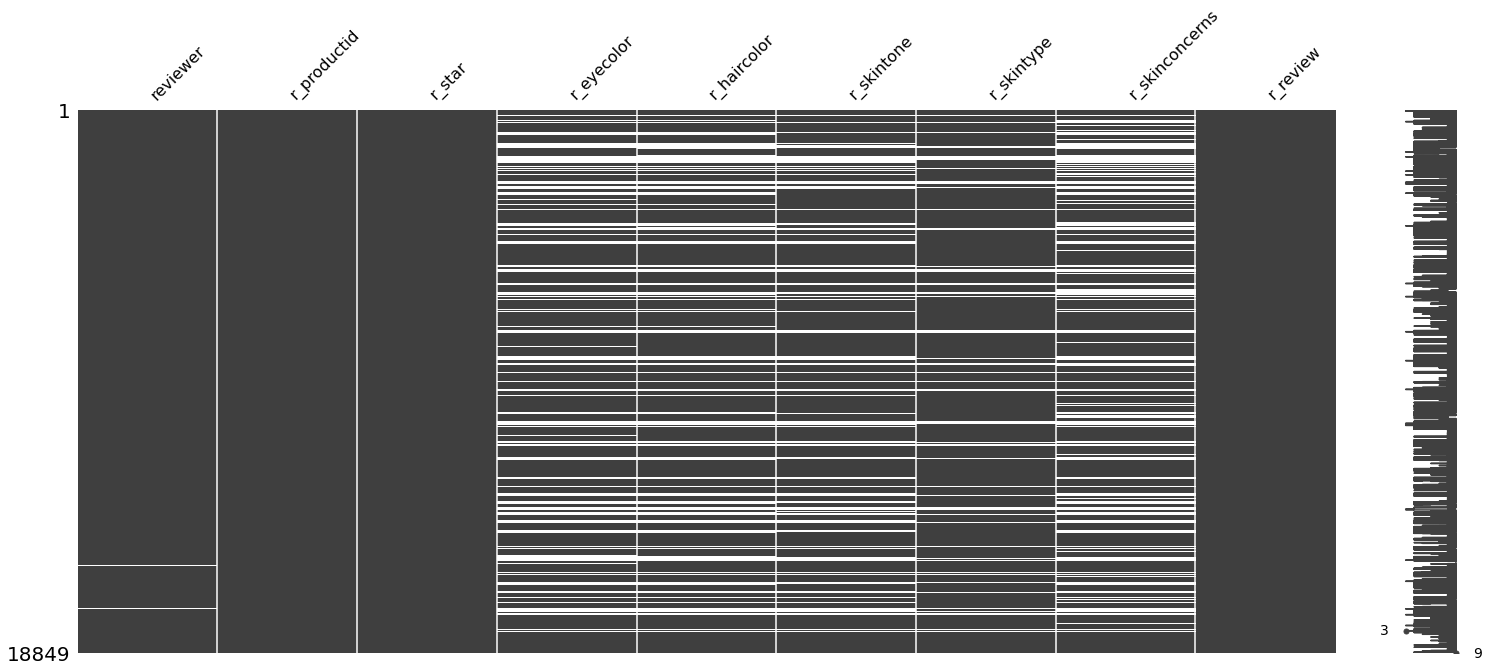

In [22]:
#Looks like reviews are complete; however, many entries have missing reviewer attributes.
msno.matrix(reviews)
plt.show()

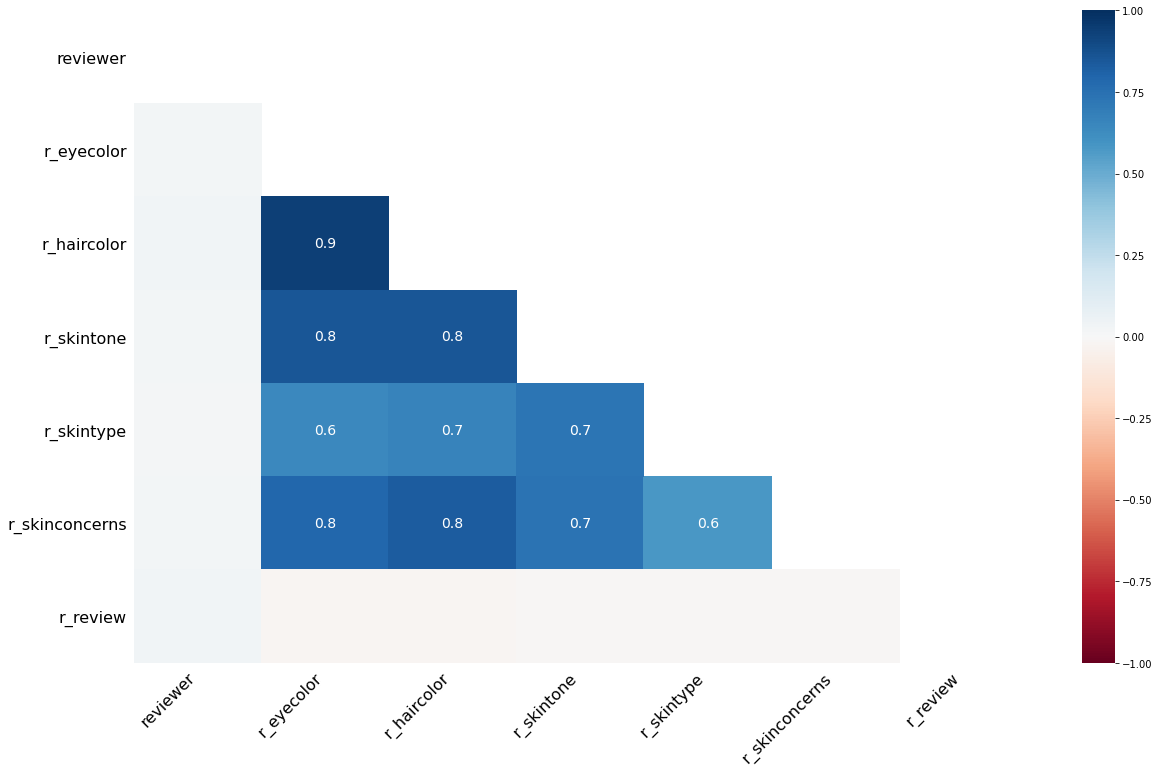

In [23]:
#Confirming type of missingness - features are related to each other; not too surprising as possibly the user did not fill in the details altogether
msno.heatmap(reviews)
plt.show()

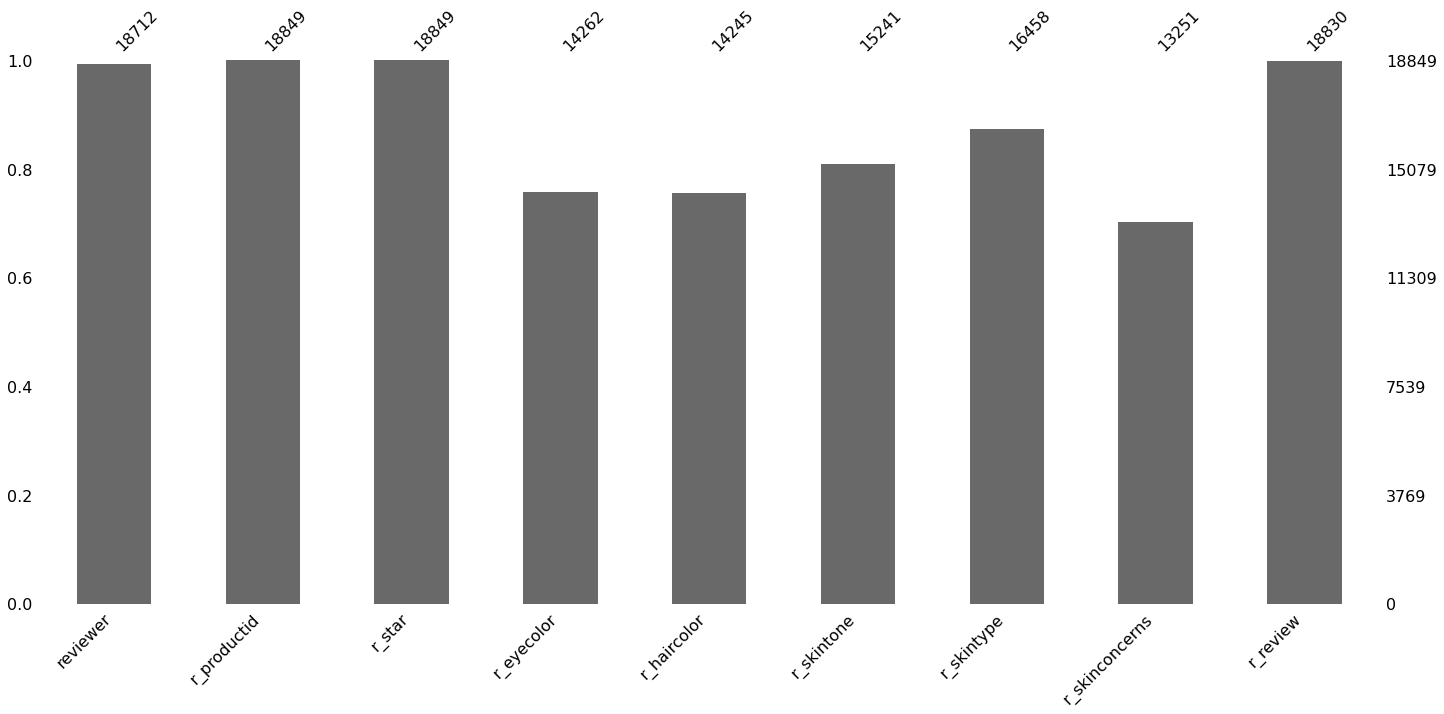

In [24]:
msno.bar(reviews)
plt.show()

In [25]:
#How many do not have all reviewer attributes 
crit= reviews['r_eyecolor'].isna() & reviews['r_haircolor'].isna() & reviews['r_skintone'].isna() & reviews['r_skintype'].isna()
print(f'{(round(reviews[crit].shape[0] / reviews.shape[0]*100,2))} % of the data have no reviewer attributes')

11.97 % of the data have no reviewer attributes


In [26]:
#Create a copy before imputing missing values
reviews_df= reviews.copy()

In [27]:
#Missing values
missing=pd.concat([reviews_df.isna().sum(), round(reviews_df.isna().mean()*100,2)], axis=1)
missing.columns = ['Missing values', '%']
missing

,Missing values,%
reviewer,137,0.73
r_productid,0,0.00
r_star,0,0.00
r_eyecolor,4587,24.34
r_haircolor,4604,24.43
r_skintone,3608,19.14
r_skintype,2391,12.69
r_skinconcerns,5598,29.70
r_review,19,0.10


In [28]:
#Impute with the mode
reviews_df['r_eyecolor'] = reviews_df.r_eyecolor.fillna(value='unspecified')
reviews_df['r_haircolor'] = reviews_df.r_haircolor.fillna(value='unspecified')
reviews_df['r_skintone'] = reviews_df.r_skintone.fillna(value='unspecified')
reviews_df['r_skinconcerns']=reviews_df['r_skinconcerns'].fillna('unspecified')
#Option to fill with most common skintype (combination) cross-checked with domain knowledge
reviews_df['r_skintype']=reviews_df['r_skintype'].fillna('unspecified')

In [29]:
#Impute empty reviews
reviews_df['r_review']=reviews_df['r_review'].fillna('')

In [30]:
pd.concat([reviews_df.isna().sum(), round(reviews_df.isna().mean()*100,2)], axis=1)

,0,1
reviewer,137,0.73
r_productid,0,0.00
r_star,0,0.00
r_eyecolor,0,0.00
r_haircolor,0,0.00
r_skintone,0,0.00
r_skintype,0,0.00
r_skinconcerns,0,0.00
r_review,0,0.00


In [32]:
reviews_df.reset_index(drop=True, inplace=True)

**Check data types**

In [28]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18849 entries, 0 to 18848
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewer        18712 non-null  object
 1   r_productid     18849 non-null  object
 2   r_star          18849 non-null  int64 
 3   r_eyecolor      18849 non-null  object
 4   r_haircolor     18849 non-null  object
 5   r_skintone      18849 non-null  object
 6   r_skintype      18849 non-null  object
 7   r_skinconcerns  18849 non-null  object
 8   r_review        18849 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.3+ MB


In [53]:
#Change into category type
reviews_df['r_eyecolor']= reviews_df.r_eyecolor.astype('category')
reviews_df['r_haircolor']= reviews_df.r_haircolor.astype('category')
reviews_df['r_skintype']= reviews_df.r_skintype.astype('category')
reviews_df['r_skintone']= reviews_df.r_skintone.astype('category')

In [52]:
reviews_df['r_skinconcerns'].value_counts()

acne               6368
unspecified        5598
aging              3704
blackheads          893
darkCircles         656
dullness            607
sensitivity         323
redness             274
sunDamage           169
cellulite           100
pores                70
unevenSkinTones      27
cuticles             22
stretchMarks         19
calluses             17
puffiness             2
Name: r_skinconcerns, dtype: int64

In [57]:
reviews_df.r_skinconcerns.replace(to_replace=['sunDamage', 'cellulite', 'pores', 'unevenSkinTones', 'cuticles', 'stretchMarks', 'calluses', 'puffiness'], value='other', inplace=True)

In [58]:
reviews_df['r_skinconcerns']= reviews_df.r_skinconcerns.astype('category')

# 3.0 Initial EDA 

### Rating

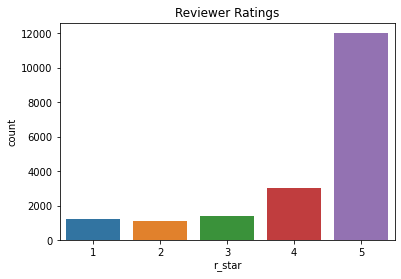

In [107]:
sns.countplot(x='r_star', data=reviews_df)
plt.title('Reviewer Ratings')
plt.show()

In [102]:
reviews_df.r_star.value_counts(normalize=True)

5    0.637222
4    0.162555
3    0.076344
1    0.064778
2    0.059101
Name: r_star, dtype: float64

This is an imbalanced dataset with majority of ratings (63.7%) fetching a 5/5

#### How does this correlate with reviewer attributes?

Eye Color

In [146]:
sns.countplot?

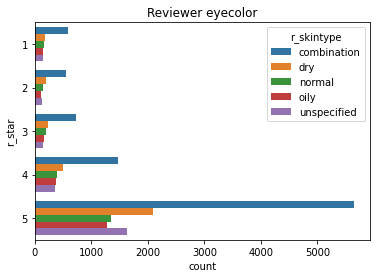

In [152]:
sns.countplot(y='r_star', data=reviews_df, orient='h', hue='r_skintype')
plt.title('Reviewer eyecolor')
plt.show()

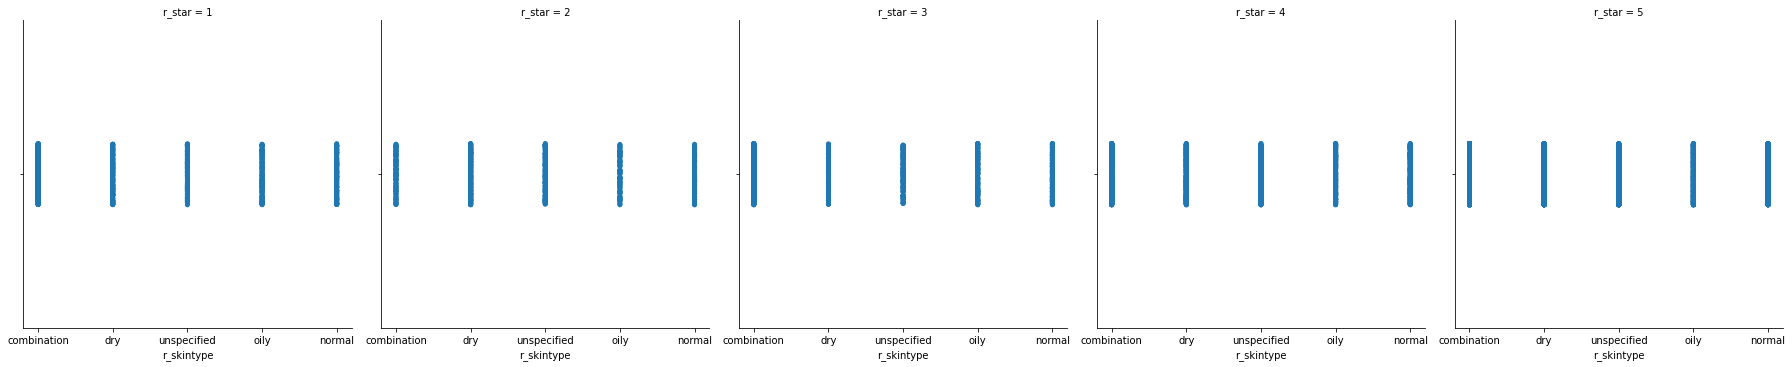

In [155]:
sns.catplot('r_skintype', data=reviews_df, col='r_star')

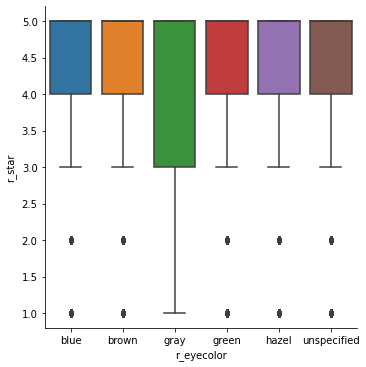

In [128]:
sns.catplot(x='r_eyecolor', y='r_star', data=reviews_df, kind='box')
plt.show()

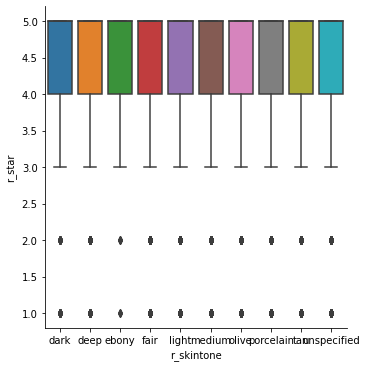

In [130]:
sns.catplot(x='r_skintone', y='r_star', data=reviews_df, kind='box')
plt.show()

#### How about skin concern and skin type?

In [103]:
reviews_df.shape

(18849, 9)

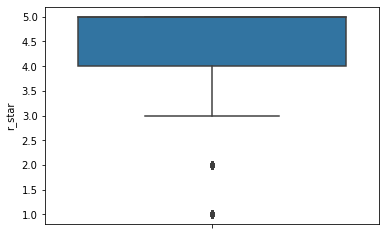

In [83]:
sns.boxplot(y='r_star', data=reviews_df)
plt.show()

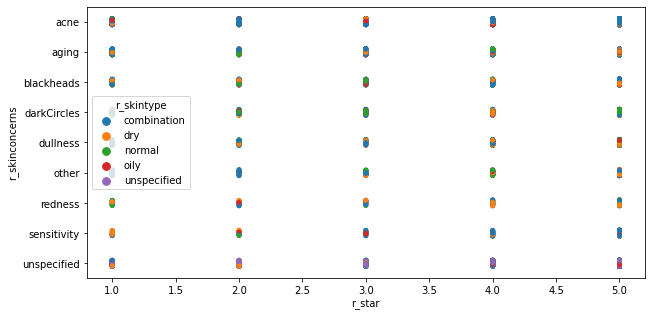

In [72]:
plt.figure(figsize=(10,5))
sns.stripplot(y='r_skinconcerns', x='r_star', data=reviews_df, hue= 'r_skintype', jitter=True)
plt.show()

In [ ]:
#Imbalanced class!
reviews_df.r_star.value_counts(normalize=True).boxplot()

In [31]:
reviews_df['r_star']= pd.to_numeric(reviews_df['r_star'])

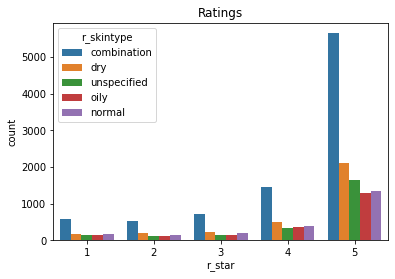

In [34]:
sns.countplot(x='r_star', data=reviews_df, hue='r_skintype', orient='h')
plt.title('Ratings')
plt.show()

In [ ]:
sns.swarmplot(x='r_skintype', y= 'r_review', data=reviews_df)
plt.show()

In [ ]:
reviews_df

In [ ]:
 Pre-processing
    4   r_haircolor     18849 non-null  object
 5   r_skintone      18849 non-null  object
 6   r_skintype      18849 non-null  object
 7   r_skinconcerns  18849 non-null  object
 8   r_review        18849 non-null  object

<font color='red'> To discuss with DJ: 
- I'd like to retain this as much as possible 
- Imputing them before training 
- to discuss whether to delete the ones where there are no reviewer attributes or no reviews at all</font>

# 4.0 Pre-processing of data

## 4.1 

## 4.2 Cleaning the reviews

In [28]:
#Change reviews type into string
reviews['r_review'] = reviews.r_review.apply(lambda x: str(x))

**Clean the text**

In [30]:
stop_words = nltk.corpus.stopwords.words('english')
def normalize_document(doc):
    '''
    Converts into string format, transforms into lowercase, 
    removes special characters and whitespaces, expands contractions
    '''
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    doc = contractions.fix(doc)
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    #filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [47]:
reviews['r_review']=reviews.r_review.apply(lambda x: normalize_document(x))

In [65]:
#Create a corpus 
corpus=[]
for i in reviews['r_review']:
    corpus.append(i)

**Lemmatize text**

In [42]:
def pos_tag_wordnet(tagged_tokens):
    tag_map = {'j': wordnet.ADJ, 'v': wordnet.VERB, 'n': wordnet.NOUN, 'r': wordnet.ADV}
    new_tagged_tokens = [(word, tag_map.get(tag[0].lower(), wordnet.NOUN))
                            for word, tag in tagged_tokens]
    return new_tagged_tokens

In [45]:
wnl= WordNetLemmatizer()

def lemmatize_text(text):
    '''
    Lemmatize the text 
    '''
    tagged_tokens= nltk.pos_tag(nltk.word_tokenize(text))
    wordnet_tokens= pos_tag_wordnet(tagged_tokens)
    lemmatized_text= ' '.join(wnl.lemmatize(word, tag) for word, tag in wordnet_tokens)
    return lemmatized_text

In [49]:
reviews['r_review']= reviews['r_review'].apply(lambda x: lemmatize_text(x))

In [50]:
reviews.head().T

,0,1,2,3,4
reviewer,kelsb5,fairytatiana,baimhas,haleymcm,mariahswannie
r_productid,P409800,P409800,P409800,P409800,P409800
r_star,5,4,5,2,4
r_eyecolor,blue,blue,blue,None,blue
r_haircolor,blonde,brunette,blonde,None,brunette
r_skintone,light,light,porcelain,None,porcelain
r_skintype,combination,combination,dry,None,dry
r_skinconcerns,acne,acne,calluses,None,darkCircles
r_review,love mini compact wipe bag buy part gift chris...,good take makeup one wipe,love watermelon one rub hard get eye makeup su...,buy green tea version wipe remove makeup someh...,nice cleanse 10 wipe though


Feature Engineering

In [ ]:
merge categories 

## 5.0 Saving dataframe to file

In [ ]:
datapath = '../data/processed_data'
if not os.path.exists(datapath):
    os.mkdir(datapath)
    
datapath_df = os.path.join(datapath, 'reviews_cleaned.json')
if not os.path.exists(datapath_df):
    reviews_df.to_json(datapath_df)

For future notebooks:
- EDA 
- Merge into main then feature engineer
    - turn into categorical or one-hot encoding